# **Importing Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

There are 2 ways to load the Fashion MNIST dataset. 


    1.   Load csv and then inherite Pytorch Dataset class .
    2.   Use Pytorch module torchvision.datasets. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c.
    
    

*   We use DataLoader class from torch.utils.data to load data in batches  in both method.
* Comment out the code of a method which you are not using. 






### 1.    Using a Dataset class.
    
   *   First load the data from the disk using pandas read_csv() method.

   *   Now inherit Dataset class in your own class that you are building,    lets say FashionData.

        *  It has 2 methods: __get_item__( ) and __len__().
        * __get_item__( ) return the images and labels and __len__( ) returns the number of items in a dataset.

In [3]:
train_csv = pd.read_csv("../input/fashion-mnist_train.csv")
test_csv = pd.read_csv("../input/fashion-mnist_test.csv")

In [4]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
        self.images = np.repeat(self.images, 3, axis=-1)

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [5]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [6]:
train_set[0][0].shape , test_set[0][0].shape

(torch.Size([3, 28, 28]), torch.Size([3, 28, 28]))

In [7]:
"""
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
"""                                          

'\ntrain_loader = torch.utils.data.DataLoader(train_set, \n                                           batch_size=100)\ntest_loader = torch.utils.data.DataLoader(test_set,\n                                          batch_size=100)\n'

### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





In [9]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 3, 28, 28])

In [10]:
len(train_set)

60000

2


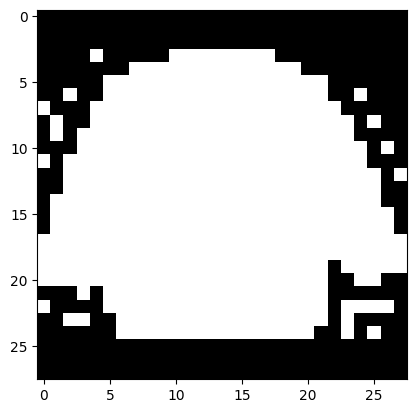

In [11]:
image, label = next(iter(train_set))
image = image.permute(1,2,0)
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [12]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 28, 28]) torch.Size([10])


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

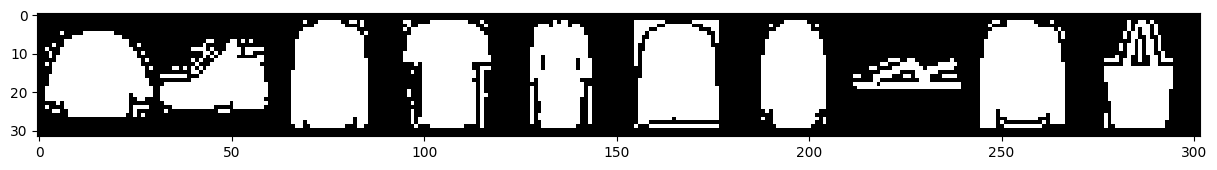

In [13]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


## Building a CNN 


*   Make a model class (WithoutVisionEagle in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision.models as models
class WithoutVisionEagle(nn.Module):
    def __init__(self, num_classes=6):
        super(WithoutVisionEagle, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.conv1 = self.resnet18.conv1
        self.bn1 = self.resnet18.bn1  
        self.relu = self.resnet18.relu  
        self.maxpool = self.resnet18.maxpool  
        self.layer1 = self.resnet18.layer1
        self.layer2 = self.resnet18.layer2
        self.layer3 = self.resnet18.layer3
        self.layer4 = self.resnet18.layer4
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)  
        x = self.relu(x) 
        x = self.maxpool(x)  
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)  
        
        return x



In [15]:
model = WithoutVisionEagle()
from torchinfo import summary
summary(model,(64,3,28,28))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.8MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
WithoutVisionEagle                       [64, 10]                  513,000
├─Conv2d: 1-1                            [64, 64, 14, 14]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 14, 14]          128
├─ReLU: 1-3                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Sequential: 1-5                        [64, 64, 7, 7]            --
│    └─BasicBlock: 2-1                   [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-1                  [64, 64, 7, 7]            36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 7, 7]            128
│    │    └─ReLU: 3-3                    [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-4                  [64, 64, 7, 7]            36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 7, 7]            128
│    │    └─ReLU: 3-6                    [64, 64, 7, 7]           

### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [16]:
model = WithoutVisionEagle()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
print(model)

WithoutVisionEagle(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [17]:
try:
  from torchsummary import summary
  print("torchsummary is already installed")
except:
  print("Installing torchsummary...")
  !pip install -q torchsummary
  from torchsummary import summary

Installing torchsummary...


In [18]:
summary(model=model, input_size=train_set[0][0].shape, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
            Conv2d-2           [-1, 64, 14, 14]           9,408
       BatchNorm2d-3           [-1, 64, 14, 14]             128
       BatchNorm2d-4           [-1, 64, 14, 14]             128
              ReLU-5           [-1, 64, 14, 14]               0
              ReLU-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,864
           Conv2d-10             [-1, 64, 7, 7]          36,864
      BatchNorm2d-11             [-1, 64, 7, 7]             128
      BatchNorm2d-12             [-1, 64, 7, 7]             128
             ReLU-13             [-1, 64, 7, 7]               0
             ReLU-14             [-1, 6

In [19]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

test_data_sampler = RandomSampler(test_set)


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)


In [21]:
try:
  from torchmetrics.classification import MulticlassAccuracy
  print("torchmetrics is already installed")
except:
  print("Installing torchmetrics...")
  !pip install -q torchmetrics
  from torchmetrics.classification import MulticlassAccuracy

torchmetrics is already installed


In [22]:
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)


In [23]:
def save_model(model, model_path, model_name="model.pth"):
  os.makedirs(model_path, exist_ok=True)
  model_save_path = os.path.join(model_path, model_name)

  torch.save(obj=model.state_dict(), f=model_save_path)
  print(f"Model_Saved_Path: '{model_save_path}'")

In [24]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

def train_model(model: torch.nn.Module,
                train_loader: DataLoader,
                test_loader: DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                epochs: int,
                device: torch.device,
                scheduler=None):
    

  # Set random seeds for reproducibility
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # Lists to store losses and accuracies for training and validation
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  best_val_epoch = 0


  for epoch in range(epochs):
    ### Training Phase ###
    train_loss, train_acc = 0, 0
    model.train()

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}\t"):
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      labels_preds = model(images)

      # Calculate loss
      loss = loss_fn(labels_preds, labels)
      train_loss += loss.item()

      # Calculate accuracy
      train_acc += accuracy_fn(labels_preds.argmax(dim=1), labels).item()

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Average loss and accuracy over the entire training set
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    ### Validation Phase ###
    val_loss, val_acc = 0, 0
    model.eval()

    with torch.inference_mode():
      for images, labels in tqdm(test_loader, desc="Validation", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass for validation
        labels_preds = model(images)

        # Calculate loss
        val_loss += loss_fn(labels_preds, labels).item()

        # Calculate validation accuracy
        val_acc += accuracy_fn(labels_preds.argmax(dim=1), labels).item()

    # Average loss and accuracy over the entire validation set
    val_loss /= len(test_loader)
    val_acc /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if(val_acc>best_val_epoch):
        best_val_epoch = val_acc
        print("saving")
        MODEL_PATH = "/kaggle/working/models"
        MODEL_NAME = "Image_Classification_Model.pth"
        save_model(model=model, model_path=MODEL_PATH, model_name=MODEL_NAME)
        
    # Print epoch results
    print(f"[Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}% | "
          f"Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc*100:.2f}%]")
    print("—" * 73)

    # Step the learning rate scheduler if it is provided
    if scheduler is not None:
      scheduler.step()
    
  # Store the history of losses and accuracies for plotting or analysis later
  history = {
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
  }

  return history

In [25]:
%%time
epochs = 100
import os
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    epochs=epochs,
    scheduler=scheduler,
    device=device,
)

Epoch 1/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.8897, Accuracy: 74.39% | Val_Loss: 0.4682, Val_Accuracy: 82.98%]
—————————————————————————————————————————————————————————————————————————


Epoch 2/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.3523, Accuracy: 87.90% | Val_Loss: 0.3232, Val_Accuracy: 87.38%]
—————————————————————————————————————————————————————————————————————————


Epoch 3/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.2855, Accuracy: 90.08% | Val_Loss: 0.3194, Val_Accuracy: 87.73%]
—————————————————————————————————————————————————————————————————————————


Epoch 4/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.2576, Accuracy: 91.05% | Val_Loss: 0.3137, Val_Accuracy: 88.69%]
—————————————————————————————————————————————————————————————————————————


Epoch 5/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.2030, Accuracy: 92.83% | Val_Loss: 0.2471, Val_Accuracy: 91.16%]
—————————————————————————————————————————————————————————————————————————


Epoch 6/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.1715, Accuracy: 93.89% | Val_Loss: 0.2676, Val_Accuracy: 90.61%]
—————————————————————————————————————————————————————————————————————————


Epoch 7/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.1487, Accuracy: 94.63% | Val_Loss: 0.2707, Val_Accuracy: 90.84%]
—————————————————————————————————————————————————————————————————————————


Epoch 8/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.1337, Accuracy: 95.17% | Val_Loss: 0.2971, Val_Accuracy: 90.58%]
—————————————————————————————————————————————————————————————————————————


Epoch 9/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.0964, Accuracy: 96.52% | Val_Loss: 0.3296, Val_Accuracy: 91.19%]
—————————————————————————————————————————————————————————————————————————


Epoch 10/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0747, Accuracy: 97.37% | Val_Loss: 0.3937, Val_Accuracy: 90.83%]
—————————————————————————————————————————————————————————————————————————


Epoch 11/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0667, Accuracy: 97.68% | Val_Loss: 0.3902, Val_Accuracy: 90.85%]
—————————————————————————————————————————————————————————————————————————


Epoch 12/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0662, Accuracy: 97.58% | Val_Loss: 0.4310, Val_Accuracy: 90.62%]
—————————————————————————————————————————————————————————————————————————


Epoch 13/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.0407, Accuracy: 98.60% | Val_Loss: 0.4264, Val_Accuracy: 91.77%]
—————————————————————————————————————————————————————————————————————————


Epoch 14/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0241, Accuracy: 99.21% | Val_Loss: 0.4873, Val_Accuracy: 91.36%]
—————————————————————————————————————————————————————————————————————————


Epoch 15/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0186, Accuracy: 99.39% | Val_Loss: 0.5792, Val_Accuracy: 90.77%]
—————————————————————————————————————————————————————————————————————————


Epoch 16/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0182, Accuracy: 99.38% | Val_Loss: 0.4948, Val_Accuracy: 91.72%]
—————————————————————————————————————————————————————————————————————————


Epoch 17/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.0112, Accuracy: 99.66% | Val_Loss: 0.4876, Val_Accuracy: 92.14%]
—————————————————————————————————————————————————————————————————————————


Epoch 18/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

saving
Model_Saved_Path: '/kaggle/working/models/Image_Classification_Model.pth'
[Loss: 0.0053, Accuracy: 99.89% | Val_Loss: 0.5101, Val_Accuracy: 92.26%]
—————————————————————————————————————————————————————————————————————————


Epoch 19/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0031, Accuracy: 99.96% | Val_Loss: 0.5250, Val_Accuracy: 92.19%]
—————————————————————————————————————————————————————————————————————————


Epoch 20/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0018, Accuracy: 99.98% | Val_Loss: 0.5385, Val_Accuracy: 92.15%]
—————————————————————————————————————————————————————————————————————————


Epoch 21/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0013, Accuracy: 99.99% | Val_Loss: 0.5455, Val_Accuracy: 92.15%]
—————————————————————————————————————————————————————————————————————————


Epoch 22/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0010, Accuracy: 99.99% | Val_Loss: 0.5509, Val_Accuracy: 92.13%]
—————————————————————————————————————————————————————————————————————————


Epoch 23/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0009, Accuracy: 100.00% | Val_Loss: 0.5557, Val_Accuracy: 92.13%]
—————————————————————————————————————————————————————————————————————————


Epoch 24/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0008, Accuracy: 100.00% | Val_Loss: 0.5604, Val_Accuracy: 92.15%]
—————————————————————————————————————————————————————————————————————————


Epoch 25/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0008, Accuracy: 100.00% | Val_Loss: 0.5623, Val_Accuracy: 92.13%]
—————————————————————————————————————————————————————————————————————————


Epoch 26/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0007, Accuracy: 100.00% | Val_Loss: 0.5642, Val_Accuracy: 92.13%]
—————————————————————————————————————————————————————————————————————————


Epoch 27/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0007, Accuracy: 100.00% | Val_Loss: 0.5662, Val_Accuracy: 92.14%]
—————————————————————————————————————————————————————————————————————————


Epoch 28/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0007, Accuracy: 100.00% | Val_Loss: 0.5678, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 29/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5687, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 30/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5696, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 31/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5704, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 32/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5713, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 33/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5717, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 34/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5721, Val_Accuracy: 92.10%]
—————————————————————————————————————————————————————————————————————————


Epoch 35/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5725, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 36/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5729, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 37/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5731, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 38/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5733, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 39/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5735, Val_Accuracy: 92.12%]
—————————————————————————————————————————————————————————————————————————


Epoch 40/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0006, Accuracy: 100.00% | Val_Loss: 0.5737, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 41/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5738, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 42/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5739, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 43/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5740, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 44/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5741, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 45/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5741, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 46/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5741, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 47/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5742, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 48/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5742, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 49/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 50/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 51/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 52/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 53/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 54/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 55/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 56/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 57/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5743, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 58/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 59/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 60/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 61/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 62/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 63/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 64/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 65/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 66/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 67/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 68/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 69/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 70/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 71/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 72/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 73/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 74/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 75/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 76/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 77/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 78/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 79/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 80/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 81/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 82/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 83/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 84/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 85/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 86/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 87/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 88/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 89/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 90/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 91/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 92/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 93/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 94/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 95/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 96/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 97/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 98/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 99/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————


Epoch 100/100	:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

[Loss: 0.0005, Accuracy: 100.00% | Val_Loss: 0.5744, Val_Accuracy: 92.11%]
—————————————————————————————————————————————————————————————————————————
CPU times: user 28min 8s, sys: 11.2 s, total: 28min 19s
Wall time: 28min 17s


In [26]:
def plot_losses(train_losses, val_losses):
  plt.plot(train_losses, label='Train Loss', color="green")
  plt.plot(val_losses, label='Val Loss', color="red")
  plt.title("Training and Validation Losses")
  # plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()

def plot_accuracies(train_accuracies, val_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy', color="green")
  plt.plot(val_accuracies, label='Val Accuracy', color="red")
  plt.title("Training and Validation Accuracies")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid()

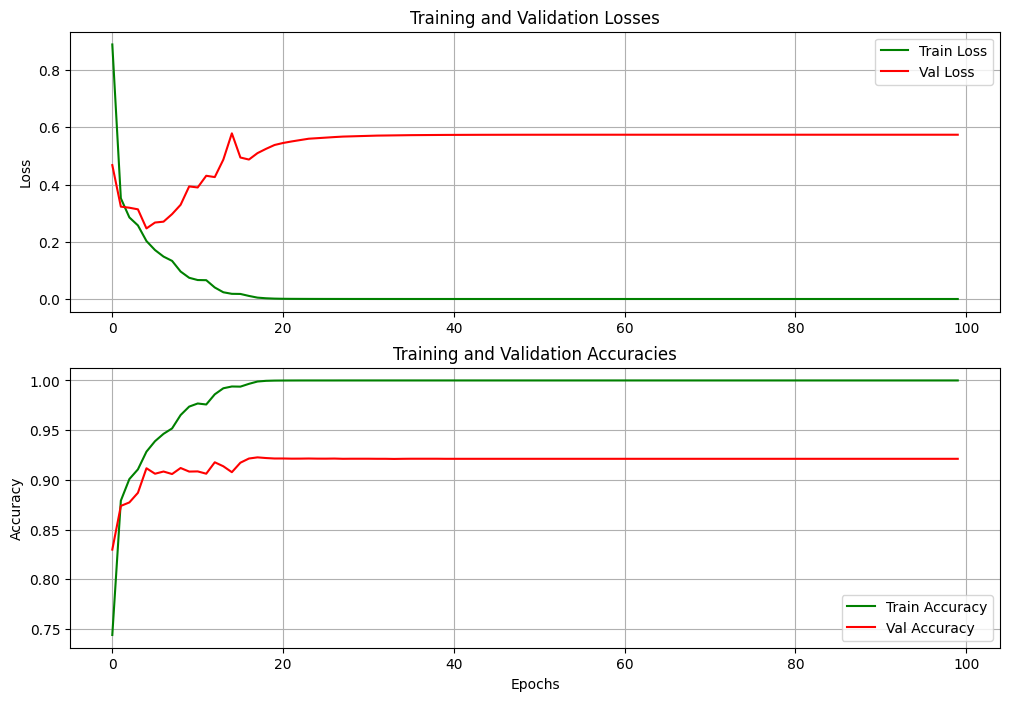

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plot_losses(history["train_losses"],history["val_losses"])

plt.subplot(2, 1, 2)
plot_accuracies(history["train_accuracies"], history["val_accuracies"])
plt.show()

In [28]:
import torch
from tqdm import tqdm

def evaluation(model: torch.nn.Module, data: DataLoader, device=device):
    total_loss, correct_predictions, total_samples = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for images, labels in tqdm(data, desc="Evaluation"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            labels_preds = model(images)
            
            # Calculate batch loss
            total_loss += loss_fn(labels_preds, labels).item() * images.size(0)  # multiply by batch size to sum

            # Calculate batch accuracy
            if labels.ndim == 2:  # if labels are one-hot encoded
                labels = labels.argmax(dim=1)
            
            correct_predictions += (labels_preds.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)

    # Average loss and accuracy over the entire validation set
    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples

    return avg_loss, avg_accuracy

In [29]:
model = WithoutVisionEagle()  

MODEL_PATH = "/kaggle/working/models"
MODEL_NAME = "Image_Classification_Model.pth"
model_load_path = os.path.join(MODEL_PATH, MODEL_NAME)

model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()  

print(f"Model Loaded from Path: '{model_load_path}'")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Loaded from Path: '/kaggle/working/models/Image_Classification_Model.pth'


/tmp/ipykernel_23/1038591799.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


In [30]:
loss, accuracy = evaluation(model, test_loader)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Evaluation: 100%|██████████| 157/157 [00:00<00:00, 159.23it/s]

Test Loss: 0.5102437705159187
Test Accuracy: 0.9228


In [31]:
def predict(model: torch.nn.Module, data_loader: DataLoader, device=device):
  model.eval()
  pred_labels = []
  true_labels = []

  with torch.inference_mode():
    for images, labels in data_loader:
      images = images.to(device)
      y_pred = model(images).argmax(dim=1)

      pred_labels.append(y_pred)
      true_labels.append(labels)

  pred_labels = torch.cat(pred_labels)
  true_labels = torch.cat(true_labels)

  return pred_labels, true_labels
pred_labels, true_labels = predict(model, test_loader)

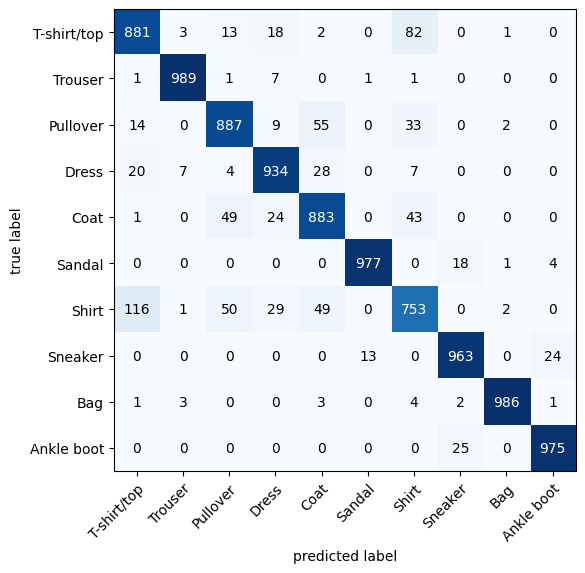

In [32]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(task="multiclass",num_classes=10).to(device)
confmat_numpy = confmat(pred_labels.to(device), true_labels.to(device)).cpu().numpy()
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
plot_confusion_matrix(
    conf_mat=confmat_numpy,
    class_names=class_names,
    figsize=(7, 6)
);


In [33]:
print("Confusion Matrix:\n", confmat_numpy)
conf_matrix = confmat_numpy

Confusion Matrix:
 [[881   3  13  18   2   0  82   0   1   0]
 [  1 989   1   7   0   1   1   0   0   0]
 [ 14   0 887   9  55   0  33   0   2   0]
 [ 20   7   4 934  28   0   7   0   0   0]
 [  1   0  49  24 883   0  43   0   0   0]
 [  0   0   0   0   0 977   0  18   1   4]
 [116   1  50  29  49   0 753   0   2   0]
 [  0   0   0   0   0  13   0 963   0  24]
 [  1   3   0   0   3   0   4   2 986   1]
 [  0   0   0   0   0   0   0  25   0 975]]


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# Sample confusion matrix (replace this with your actual matrix)

num_classes = conf_matrix.shape[0]

# Initialize lists to store metrics for each class
precision = []
recall = []
specificity = []
f1_scores = []
mcc_scores = []

# Calculate metrics for each class
for i in range(num_classes):
    # True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    # Precision for the current class
    precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
    precision.append(precision_i)

    # Sensitivity (Recall) for the current class
    recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0
    recall.append(recall_i)

    # Specificity for the current class
    specificity_i = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity.append(specificity_i)

    # F1 Score for the current class
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0
    f1_scores.append(f1_i)

    # MCC for the current class
    mcc_i = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 0
    mcc_scores.append(mcc_i)

# Calculate accuracy
accuracy = np.sum(np.diagonal(conf_matrix)) / np.sum(conf_matrix)

# Calculate averages
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_specificity = np.mean(specificity)
avg_f1_score = np.mean(f1_scores)
avg_mcc = np.mean(mcc_scores)

# Create a table format with metrics
metrics = {
    'Class': [f'C{i+1}' for i in range(num_classes)],
    'Precision': precision,
    'Sensitivity (Recall)': recall,
    'Specificity': specificity,
    'F1 Score': f1_scores,
    'MCC': mcc_scores
}

# Convert to DataFrame for better display
df_metrics = pd.DataFrame(metrics)

# Add accuracy row and average row at the end
df_metrics.loc['Accuracy'] = ['Accuracy', accuracy, '-', '-', '-', '-']
df_metrics.loc['Average'] = ['Average', avg_precision, avg_recall, avg_specificity, avg_f1_score, avg_mcc]

# Display the metrics table
import IPython.display as display
display.display(df_metrics)

,Class,Precision,Sensitivity (Recall),Specificity,F1 Score,MCC
0,C1,0.852031,0.881,0.983,0.866273,0.851286
1,C2,0.986042,0.989,0.998444,0.987519,0.986131
2,C3,0.883466,0.887,0.987,0.88523,0.872451
3,C4,0.914789,0.934,0.990333,0.924295,0.915847
4,C5,0.865686,0.883,0.984778,0.874257,0.860184
5,C6,0.985873,0.977,0.998444,0.981416,0.979374
6,C7,0.815818,0.753,0.981111,0.783151,0.760871
7,C8,0.955357,0.963,0.995,0.959163,0.954615
8,C9,0.993952,0.986,0.999333,0.98996,0.988859
9,C10,0.971116,0.975,0.996778,0.973054,0.970056
